In [1]:
# This notebook have built from this tutorial: https://github.com/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb
import os

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Logger detectron2 (DEBUG)>

In [2]:
import torch
torch.cuda.empty_cache()  # Free up unutilized memory

checking the version and if we have cuda available

In [4]:
from src.segmentation.framework_handlers.detectron2_handler import print_version_info

!nvcc --version
print_version_info()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
torch:  1.9 ; cuda:  11.1
detectron2: 0.6


In [5]:
!python --version

Python 3.9.19


In [6]:
!nvidia-smi

Wed Jul 10 18:44:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  |   00000000:04:00.0 Off |                  N/A |
| 36%   57C    P0             68W /  250W |       1MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!pip list | grep torch

torch                   1.9.1+cu111
torchaudio              0.9.1
torchvision             0.10.1+cu111


### Exporting the segments train and test dataset and regeister then to the detectron2 package

Remember!! when loading datasets from segments the images will be saved to the segments folder and the json coco annotations file will be save to the `saving_path` defined

In [8]:
from datetime import datetime

# Get the current date and time of the model training process
current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
current_time

'10-07-2024_18-44-11'

In [9]:
model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x"
detectron2_models_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2"
model_saving_path = os.path.join(detectron2_models_path, model, current_time)
print(model_saving_path)

/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/10-07-2024_18-44-11


In [13]:
from src.segmentation.framework_handlers.detectron2_handler import prepare_and_register_datasets

dataset_name_train = "etaylor/cannabis_patches_train_26-04-2024_15-44-44"
dataset_name_test = "etaylor/cannabis_patches_test_26-04-2024_15-44-44"
release_train = "v0.1"
release_test = "v0.1"
detectron2_models_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2"
model_saving_path = os.path.join(detectron2_models_path, model, current_time)

metadata_train, dataset_dicts_train, metadata_test, dataset_dicts_test = prepare_and_register_datasets(dataset_name_train, dataset_name_test, release_train, release_test)

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 395/395 [00:00<00:00, 429.55it/s]


Initialized dataset with 395 images.
Exporting dataset. This may take a while...


100%|██████████| 395/395 [00:08<00:00, 47.07it/s]


Exported to ./export_coco-instance_etaylor_cannabis_patches_train_26-04-2024_15-44-44_v0.1.json. Images in segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/v0.1
Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 108/108 [00:00<00:00, 406.80it/s]


Initialized dataset with 108 images.
Exporting dataset. This may take a while...


100%|██████████| 108/108 [00:02<00:00, 49.75it/s]


Exported to ./export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json. Images in segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/v0.1
WARNING [07/10 18:44:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/10 18:44:54 d2.data.datasets.coco]: Loaded 369 images in COCO format from segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_train_26-04-2024_15-44-44_v0.1.json
WARNING [07/10 18:44:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/10 18:44:54 d2.data.datasets.coco]: Loaded 106 images in COCO format from segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json


plot train samples with annotations

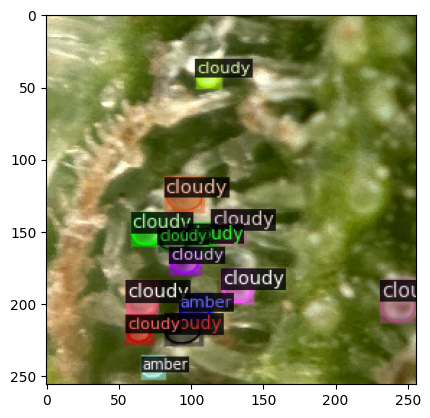

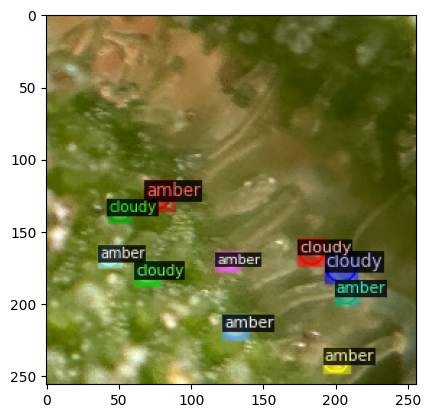

In [13]:
from src.segmentation.framework_handlers.detectron2_handler import plot_train_samples

plot_train_samples(dataset_dicts_train, metadata_train, indices=[1,2])

Define the training params and to which model to fine tune

In [14]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

In [15]:
cfg = get_cfg()
cfg.OUTPUT_DIR = model_saving_path
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml"))
cfg.DATASETS.TRAIN = (dataset_name_train,)
cfg.DATASETS.TEST = ()
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"{model}.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given configuration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[07/10 18:45:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

In [16]:
trainer.train() # Start the training process

[07/10 18:45:04 d2.engine.train_loop]: Starting training from iteration 0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its dat

[07/10 18:45:10 d2.utils.events]:  eta: 0:04:25  iter: 19  total_loss: 3.83  loss_cls: 1.448  loss_box_reg: 0.282  loss_mask: 0.693  loss_rpn_cls: 1.242  loss_rpn_loc: 0.1066    time: 0.2729  last_time: 0.2964  data_time: 0.0169  last_data_time: 0.0042   lr: 4.9953e-06  max_mem: 3024M
[07/10 18:45:19 d2.utils.events]:  eta: 0:04:33  iter: 39  total_loss: 3.632  loss_cls: 1.347  loss_box_reg: 0.4066  loss_mask: 0.6884  loss_rpn_cls: 1.087  loss_rpn_loc: 0.1176    time: 0.2838  last_time: 0.3172  data_time: 0.0053  last_data_time: 0.0181   lr: 9.9902e-06  max_mem: 3457M
[07/10 18:45:24 d2.utils.events]:  eta: 0:04:26  iter: 59  total_loss: 2.656  loss_cls: 1.138  loss_box_reg: 0.3882  loss_mask: 0.6764  loss_rpn_cls: 0.3595  loss_rpn_loc: 0.07555    time: 0.2807  last_time: 0.2563  data_time: 0.0055  last_data_time: 0.0034   lr: 1.4985e-05  max_mem: 3457M
[07/10 18:45:30 d2.utils.events]:  eta: 0:04:17  iter: 79  total_loss: 2.446  loss_cls: 0.9433  loss_box_reg: 0.5106  loss_mask: 0.659

In [17]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
print(f"saving config to {config_yaml_path}")
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

saving config to /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/10-07-2024_18-44-11/config.yaml


In [18]:
cfg.OUTPUT_DIR

'/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/10-07-2024_18-44-11'

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

### In order to keep playing with the model use `predictor`

Plot model predictions on test set

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_test_predictions

plot_test_predictions(dataset_dicts_test, metadata_test, predictor)

#### Register new test set and evaluate metrics

In [ ]:
# Register new test set
from src.segmentation.framework_handlers.detectron2_handler import convert_segments_to_coco_format
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

dataset_name_test = "etaylor/cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285"
release_test = "v0.2"

# Convert segments dataset to coco format for testing dataset
_, test_export_json_path, test_saved_images_path = convert_segments_to_coco_format(
    dataset_name=dataset_name_test, 
    release_version=release_test, 
)

register_coco_instances(dataset_name_test, {}, test_export_json_path, test_saved_images_path)

metadata_test = MetadataCatalog.get(dataset_name_test)
dataset_dicts_test = DatasetCatalog.get(dataset_name_test)

Evaluate the performance of the trained model on the test dataset using the `COCOEvaluator`

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluator
from detectron2.data import build_detection_test_loader
import json

evaluator = COCOEvaluator(dataset_name_test, output_dir=os.path.join(cfg.OUTPUT_DIR, dataset_name_test))
val_loader = build_detection_test_loader(cfg, dataset_name_test)
eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Check if the directory exists
output_dir = os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
eval_results_saving_path = os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test), "evaluation_results.json")
# Save the eval_results dictionary to a JSON file
with open(eval_results_saving_path, 'w') as file:
    json.dump(eval_results, file, indent=4)

WARNING [07/10 18:53:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/10 18:53:23 d2.data.datasets.coco]: Loaded 106 images in COCO format from segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/export_coco-instance_etaylor_cannabis_patches_test_26-04-2024_15-44-44_v0.1.json
[07/10 18:53:23 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  trichome  | 0            |   clear    | 549          |   cloudy   | 862          |
|   amber    | 114          |            |              |            |              |
|   total    | 1525         |            |              |            |              |
[07/10 18:53:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge

[07/10 18:53:29 d2.evaluation.evaluator]: Inference done 89/106. Dataloading: 0.0008 s/iter. Inference: 0.0570 s/iter. Eval: 0.0066 s/iter. Total: 0.0645 s/iter. ETA=0:00:01
[07/10 18:53:30 d2.evaluation.evaluator]: Total inference time: 0:00:06.497792 (0.064335 s / iter per device, on 1 devices)
[07/10 18:53:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.056639 s / iter per device, on 1 devices)
[07/10 18:53:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/10 18:53:30 d2.evaluation.coco_evaluation]: Saving results to /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/10-07-2024_18-44-11/etaylor/cannabis_patches_test_26-04-2024_15-44-44/coco_instances_results.json
[07/10 18:53:30 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[07/10 18:53:30 d2.evaluation.fast_e

In [24]:
print(eval_results)

OrderedDict([('bbox', {'AP': 17.42179298878143, 'AP50': 23.647556686677145, 'AP75': 21.361596446650175, 'APs': 16.968916114907927, 'APm': 17.070943825813917, 'APl': nan, 'AP-trichome': nan, 'AP-clear': 1.4785478547854785, 'AP-cloudy': 46.41059348779643, 'AP-amber': 4.376237623762377}), ('segm', {'AP': 17.903805324469204, 'AP50': 23.257224165704226, 'AP75': 21.333715664379692, 'APs': 13.462760839859127, 'APm': 18.348693946512768, 'APl': nan, 'AP-trichome': nan, 'AP-clear': 1.5123762376237624, 'AP-cloudy': 47.59507933974423, 'AP-amber': 4.603960396039604})])


#### Segment images and save object level information into a csv file.



In [11]:
from src.segmentation.framework_handlers.detectron2_handler import extract_object_info_to_csv

dataset_directory = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753" 
input_images_directory = os.path.join(dataset_directory, "v0.1")
csv_file_name = "detected_objects.csv"
output_csv_path = os.path.join(dataset_directory,csv_file_name)

extract_object_info_to_csv(input_images_directory, output_csv_path, predictor, metadata_train)

'Object-level information saved to CSV file at /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753/detected_objects.csv'

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_class_statistics

plot_class_statistics(output_csv_path, metadata_train)

/tmp/ipykernel_24632/3811209441.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


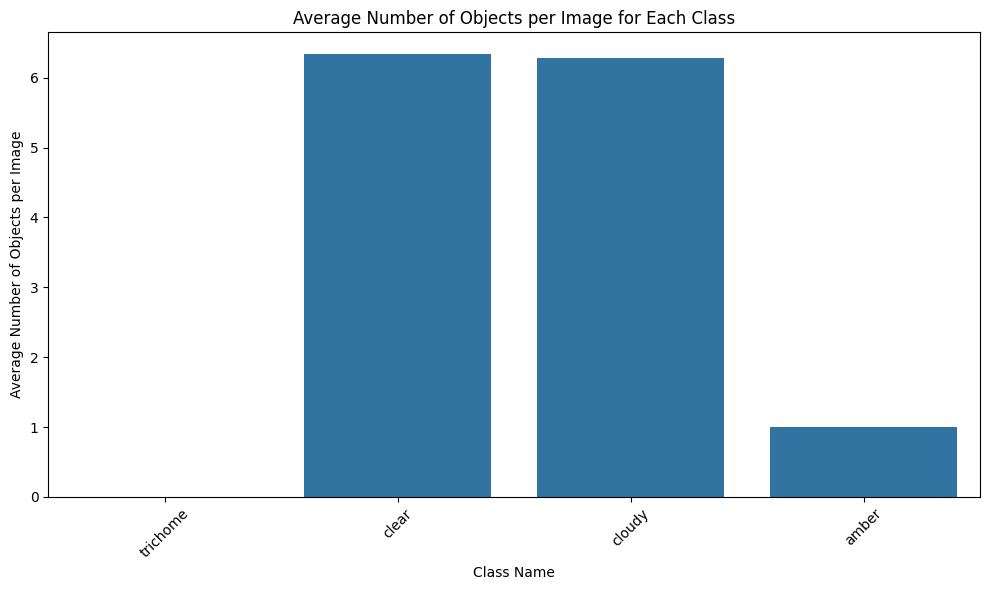

/tmp/ipykernel_24632/3811209441.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)


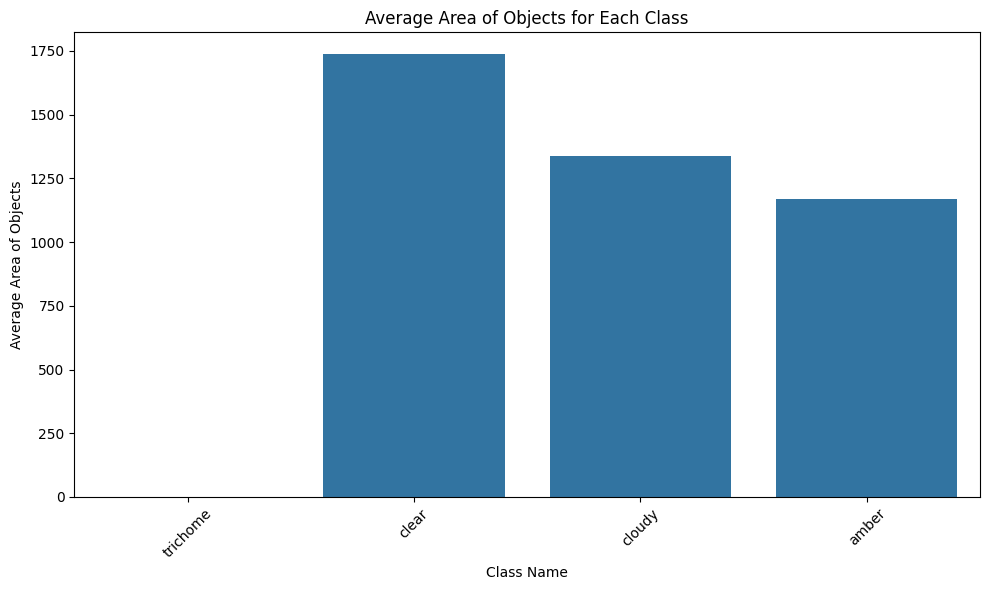

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(output_csv_path)

# Get class names from train_metadata.thing_classes
class_names = metadata_train.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()
